# Midi Composer Classifier

In [19]:
training_path = 'MusicNet\\PS1'
prediction_path = 'MusicNet\\PS2'
stream_size = 30

#### Import Necessary Libraries

In [197]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import pretty_midi

import warnings 
from os import listdir
from os.path import join

### Collect Known Data

In [2]:
def flatten(xss):
    """
    This function flattens a list of list of lists into a list of lists
    
    @input features: list of list of lists
    @type features: list of list of lists
    
    @return: list of lists
    @rtype: list of lists
    """
    return [x for xs in xss for x in xs]

In [3]:
def normalize_features(features):
    """
    This function normalizes the features to the range [-1, 1]
    
    @input features: The array of features.
    @type features: List of float
    
    @return: Normalized features.
    @rtype: List of float
    """
    tempo = (features[0] - 150) / 300
    resolution = (features[1] - 260) / 400
    num_tempo_changes = (features[2] - 2) / 10
    num_sig_changes = (features[3] - 2) / 10
    num_instruments = (features[4] - 5) / 40
    
    return [tempo, resolution, num_tempo_changes,
            num_sig_changes, num_instruments]

In [31]:
def get_tempo(tempo_changes, chunk_min, chunk_max):
    """
    Retreives tempo at start of chunk and,
    number of tempo changes for a given chunk
    
    @input tempo_changes: total list of tempo changes
    @type instruments: pretty_midi.Instrument
    @input chunk_min: time of starting chunk
    @type chunk_min: int
    @input chunk_max: time of ending chunk
    @type chunk_max: int
    
    @return: starting tempo and number of tempo changes in for chunk
    @rtype: [float, Int]
    """
    tempo = tempo_changes[0][1]
    num_tempo_changes = 0
    
    for i_tempo in tempo_changes:
        if chunk_min <= i_tempo[0] <= chunk_max:
            tempo = i_tempo[1]
            num_tempo_changes += 1
    
    return [tempo, num_tempo_changes]

def get_num_sig_changes(time_sig_changes, chunk_min, chunk_max):
    """
    Retreives number of time signature changes for a given chunk
    
    @input time_sig_changes: total list of time signature changes
    @type instruments: pretty_midi.Instrument
    @input chunk_min: time of starting chunk
    @type chunk_min: int
    @input chunk_max: time of ending chunk
    @type chunk_max: int
    
    @return: number of time signature changes
    @rtype: Int
    """
    num_sig_changes = 0
    
    for i_time_sig in time_sig_changes:
        if chunk_min <= i_time_sig.time <= chunk_max:
            num_sig_changes += 1
    
    return num_sig_changes

def get_num_instruments(instruments, chunk_min, chunk_max, fs_min, fs_max):
    """
    Retreives number of instruments for a given chunk
    
    @input instruments: total list of instruments
    @type instruments: pretty_midi.Instrument
    @input chunk_min: time of starting chunk
    @type chunk_min: int
    @input chunk_max: time of ending chunk
    @type chunk_max: int
    @input fs_min: relates to start time of chunk
    @type fs_min: int
    @input fs_max: relates to end time of chunk
    @type fs_max: int
    
    @return: number of instruments
    @rtype: Int
    """
    num_instruments = 0
    
    for i_instrument in instruments:
        instrument_value = sum(sum(i_instrument.get_piano_roll())[fs_min:fs_max])
        if instrument_value != 0:
            num_instruments += 1
    
    return num_instruments

def get_fs_frac(file, num_chunks):
    """
    gets the size of fs_frac, which is dependent on chunk_size
    
    @input file: midi file path
    @type file: String
    @input num_chunks: number of chunks in this file's length
    @type num_chunks: int
    
    @return: fraction of fs
    @rtype: Int
    """
    piano_roll = file.get_piano_roll()
    fs = piano_roll.shape[1]
    return (fs/num_chunks).astype('int')

def split_midi_features(file, chunk_size):
    """
    Splits midi files into a number of sizes depending on chunk size.
    Retrieves features for each midi file chunk
    
    @input file: midi file path
    @type file: String
    @input chunk_size: length of streaming chunk
    @type chunk_size: int
    
    @return: Extracted features
    @rtype: List of lists of floats
    """
    song_length = file.get_end_time()
    num_chunks = np.floor(song_length/chunk_size).astype('int')
    if num_of_chunks < 1:
        num_of_chunks = 1
    
    tempo_changes = file.get_tempo_changes()
    resolution = file.resolution
    time_sig_changes = file.time_signature_changes
    instruments = file.instruments
    
    fs_frac = get_fs_frac(file, num_chunks)
    
    list_of_chunk_features = []
    
    for i in range(num_chunks):
        chunk_min = chunk_size*(i)
        chunk_max = chunk_size*(i+1)
        
        fs_min = fs_frac*(i)
        fs_max = fs_frac*(i+1)
        
        tempo, num_tempo_changes = get_tempo(tempo_changes, chunk_min, chunk_max)
        num_sig_changes = get_num_sig_changes(time_sig_changes, chunk_min, chunk_max)
        num_instruments = get_num_instruments(instruments, chunk_min, chunk_max, fs_min, fs_max)
        
        norm_features = normalize_features([tempo, resolution, num_tempo_changes, 
                        num_sig_changes, num_instruments])
        
        list_of_chunk_features.append(norm_features)
    

    return list_of_chunk_features
    

In [32]:
def midi_features(file, chunk_size):
    """
    Retrieves features for midi files
    
    @input file: midi file path
    @type file: String
    
    @return: Extracted features
    @rtype: List of floats
    """
    resolution = file.resolution
    
    song_length = file.get_end_time()
    num_chunks = np.floor(song_length/chunk_size).astype('int')
    fs_frac = get_fs_frac(file, num_chunks)
    
    tempo, num_tempo_changes = get_tempo(file.get_tempo_changes(), 0, chunk_size)
    num_sig_changes = get_num_sig_changes(file.time_signature_changes, 0, chunk_size)
    num_instruments = get_num_instruments(file.instruments, 0, chunk_size, 0, fs_frac)
    
    return normalize_features([tempo, resolution, num_tempo_changes, 
                        num_sig_changes, num_instruments])

In [33]:
def get_features(song, chunk_size=30, split_midi=False):
    """
    This function checks for a corrupt midi file, 
    it extracts certain features, and creates a list of lists.
    
    @input song: midi file path
    @type song: String
    
    @return: Extracted features
    @rtype: List of lists
    """
    try:
        # Test for Corrupted Midi Files
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            file = pretty_midi.PrettyMIDI(song)
            
            if split_midi:
                return split_midi_features(file, chunk_size)
            
            return midi_features(file, chunk_size)
                
    
    except:
        return None
    

In [6]:
def composers_list(path, composer, chunk_size):
    """
    This function takes a folder location and a composer folder name, 
    and returns a list of songs with features.
    
    @input path: folder of composer folders
    @type path: String
    @input composer: folder of composer's songs
    @type composer: String
    
    @return: Songs (w/ features) of composer
    @rtype: List of lists
    """
    print(composer)
    all_features = []
    composer_path = join(path, composer)

    for song in listdir(composer_path):
        song_path = join(composer_path, song) 
        chunk_features = get_features(song_path, chunk_size, split_midi=True)
        
        if chunk_features is not None:
            for features in chunk_features:
                features.append(composer)
                all_features.append(features)
    
    return all_features

# Creates midi list with features for each composer 
composers = listdir(training_path)
composers_features = [composers_list(training_path, composer, stream_size) for composer in composers]

labeled_features = flatten(composers_features)
print(f'{len(labeled_features)} midi segments')

Bach
Beethoven
Brahms
Schubert
2273 midi segments


In [7]:
labeled_features[0]

[0.24571441000000002, 0.55, -0.1, -0.1, -0.1, 'Bach']

### Partition Dataset and Format Features

In [185]:
composer_label = {'Bach' : 0, 'Beethoven' : 1, 'Brahms' : 2, 'Schubert' : 3}

def partition_dataset(labeled_features):
    """
    Separates labeled_features into 3 groups:
    60% for training, 20% for validation, and 20% for testing accuracy
    
    @input labeled_features: The total list of labeled features
    @type labeled_features: list of mostly floats and one String column
    
    @return: the three separate groups of data
    @rtype: list of lists
    """
    num = len(labeled_features)
    num_training = int(num * 0.6)
    num_validation = int(num * 0.8)
    training_data = labeled_features[:num_training]
    validation_data = labeled_features[num_training:num_validation]
    test_data = labeled_features[num_validation:]
    
    return [training_data, validation_data, test_data]

def get_data_features(data, num_cols):
    """
    Makes a feature list from data
    
    @input data: The total label_feature data
    @type data: list of mostly floats and one String column
    @input num_cols: The number of columns in each labeled_feature
    @type num_cols: int
    
    @return: array of all features of that category of data
    @rtype: numpy array of floats
    """
    return np.array(data[:, :num_cols]).astype('float')

def get_data_labels(data, num_cols):
    """
    Makes a label list from data. Then converts composer's name to an int value
    
    @input data: The total label_feature data
    @type data: list of mostly floats and one String column
    @input num_cols: The number of columns in each labeled_feature
    @type num_cols: int
    
    @return: array of all labels of that category of data
    @rtype: numpy array of ints
    """
    labels_list = [composer_label[person] for person in data[:, num_cols]]
    return np.array(labels_list).astype('int')

def partition_dataset_and_format_features(labeled_features):
    """
    This function first randomizes the order of labeled_features,
    then separates features and labels from each other.
    
    @input labeled_features: The total list of labeled features
    @type labeled_features: list of mostly floats and one String column
    
    @return: Two dictionaries, one for features and one for labels
    @rtype: list of 2 dictionaries
    """
    # Shuffle Entire Dataset to Make Random
    labeled_features = np.random.permutation(labeled_features)
    
    # Partition into 3 sets
    training_data, validation_data, test_data = partition_dataset(labeled_features)
    
    # Separate Features from Labels
    num_cols = training_data.shape[1] - 1
    training_features = get_data_features(training_data, num_cols)
    validation_features = get_data_features(validation_data, num_cols)
    test_features = get_data_features(test_data, num_cols)
    
    features = {
        'train' : training_features,
        'validate' : validation_features,
        'test' : test_features
    }
    
    # Format Features for Multi-class Classification
    training_labels = get_data_labels(training_data, num_cols)
    validation_labels = get_data_labels(validation_data, num_cols)
    test_labels = get_data_labels(test_data, num_cols)
    
    labels = {
        'train' : training_labels,
        'validate' : validation_labels,
        'test' : test_labels
    }

    return [features, labels]

# Function for One-Hot Encoding
def one_hot(labels):
    """
    This function encodes the labels using one-hot encoding.
    
    @input num_classes: The number of genres/classes.
    @type num_classes: int
    @input labels: The genre labels to encode.
    @type labels: list of int
    
    @return: The one-hot encoding of the labels.
    @rtype: numpy.ndarray of int
    """
    return np.eye(len(composers))[labels].astype(int)

# Print to Check Dimentions and to Visualize
features, labels = partition_dataset_and_format_features(labeled_features)

print(features['test'][:5])
print(labels['test'][:5])
print(one_hot(labels['test'])[:5])

[[-0.49347826  0.31       -0.2        -0.2        -0.075     ]
 [-0.475       0.31       -0.1        -0.1        -0.075     ]
 [-0.424       0.31       -0.1        -0.1        -0.075     ]
 [-0.4475      0.31       -0.2        -0.2        -0.075     ]
 [-0.31333323  0.31       -0.1        -0.2        -0.025     ]]
[1 1 1 1 1]
[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]


### Construct Models to Fit Labeled Features

In [186]:
def train_model(t_features, t_labels, v_features, v_labels):
    """
    This function trains a neural network using a couple different configurations.
    
    @input t_features: The training features.
    @type t_features: numpy.ndarray of float
    @input t_labels: The training labels.
    @type t_labels: numpy.ndarray of int
    @input v_features: The validation features.
    @type v_features: numpy.ndarray of float
    @input v_labels: The validation labels.
    @type v_labels: numpy.ndarray of int
    
    @return: The classifier that achieved the best validation accuracy.
    @rtype: sklearn.neural_network.multilayer_perceptron.MLPClassifier
    """
    # Neural Network and SVM Configurations
    clf_list = []
    #clf_list.append(MLPClassifier(hidden_layer_sizes=(5), random_state=1, max_iter=1000))
    #clf_list.append(MLPClassifier(hidden_layer_sizes=(5, 5), random_state=1, max_iter=5000))
    #clf_list.append(MLPClassifier(hidden_layer_sizes=(10, 10), random_state=1, max_iter=5000))
    #clf_list.append(MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1, max_iter=1000))
    #clf_list.append(SVC())
    clf_list.append(KNeighborsClassifier(n_neighbors=5))
    
    # Keep Track of the Best Model
    best_clf = None
    best_accuracy = 0
    
    # Test the Accuracies of the Models and Get Best
    for clf in clf_list:
        t_labels_hot = one_hot(t_labels)
        v_labels_hot = one_hot(v_labels)
        
        if (type(clf) == SVC):
            clf = clf.fit(t_features, t_labels)
        else:
            clf = clf.fit(t_features, t_labels_hot)
            
        predictions = clf.predict(v_features)
        count = 0
        
        for i in range(len(v_labels)):
            if (type(clf) != SVC):
                if np.array_equal(v_labels_hot[i], predictions[i]):
                    count += 1
            else:
                if v_labels[i] == predictions[i]:
                    count += 1
                    
        accuracy = count / len(v_labels_hot)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_clf = clf

    #print("Best Accuracy:", best_accuracy)
    #print("Best Classifier:", best_clf)
    
    return best_clf

# Find classifier with the best accuracy
classifier = train_model(features['train'], labels['train'], features['validate'], labels['validate'])

### Calculate Test Accuracy

In [178]:
def calculate_accuracy(clf, t_features, t_labels):
    """
    This function takes a trained model as well as the test features and its
    corresponding labels, and reports the accuracy of the model.
    
    @input clf: The trained classifier.
    @type model: sklearn.neural_network.multilayer_perceptron.MLPClassifier
    @input t_features: The features from the test set.
    @type f_features: numpy.ndarray of float
    @input t_labels: The labels of the test set features.
    @type t_labels: numpy.ndarray of int
    
    @return: The accuracy.
    @rtype: float
    """
    count = 0
    predictions = clf.predict(t_features)
    t_labels_hot = one_hot(t_labels)
    for i in range(len(t_features)):
        if (type(clf) == SVC):
            if t_labels[i] == predictions[i]:
                count += 1
        else:
            if np.array_equal(t_labels_hot[i], predictions[i]):
                count += 1
    return count / len(t_features)

# Print the Test Accuracy
print(calculate_accuracy(classifier, features['test'], labels['test']))

0.9494505494505494


### Predict PS2 midi composers

In [179]:
def make_prediction(clf, midi_path):
    """
    This function uses the classifier to predict the genre of a midi file.
    
    @input clf: The trained classifier.
    @type clf: sklearn.neural_network.multilayer_perceptron.MLPClassifier
    @input midi_path: The path to the midi file that we are trying to classify.
    @type midi_path: String
    
    @return: The predicted genre of the midi file.
    @rtype: String
    """
    features = get_features(midi_path, chunk_size=stream_size, split_midi=False)
    
    if features is None:
        return 'None'
    
    if (type(clf) != SVC):
        prediction = list(clf.predict([features])[0])
        
        if prediction == [0,0,0,0]:
            return 'Other'
        
        prediction_ind = prediction.index(1)
    
    else:
        prediction_ind = clf.predict([features])[0]
    
    return [k for k, v in composer_label.items() if v == prediction_ind][0]
    
    

    
# Make a Prediction
midi_list = [midi for midi in listdir(prediction_path)]

df = pd.DataFrame({'midi':midi_list})

df['composer'] = df.apply (lambda row: make_prediction(classifier, join(prediction_path, row.midi)), axis=1)

other_composers = df.loc[(df['composer'] == 'Other')]
other_composers

,midi,composer
6,0.10222964826466285_adj.mid,Other
28,0.647959423719129_adj.mid,Other


## Making histogram of it's predictions

In [196]:
count_vals = []

midi_list = [midi for midi in listdir(prediction_path)]

for i in range(50):
    # Print to Check Dimentions and to Visualize
    features, labels = partition_dataset_and_format_features(labeled_features)

    # Find classifier with the best accuracy
    classifier = train_model(features['train'], labels['train'], features['validate'], labels['validate'])
    
    # Make a Prediction
    df = pd.DataFrame({'midi':midi_list})
    df['composer'] = df.apply (lambda row: make_prediction(classifier, join(prediction_path, row.midi)), axis=1)

    other_composers = df.loc[(df['composer'] == 'Other')]
    count_vals.append(other_composers.index.values.tolist())
    
Counter(flatten(count_vals))

Counter({15: 2, 26: 16, 30: 3, 10: 8, 20: 22, 23: 17, 6: 3, 28: 3})

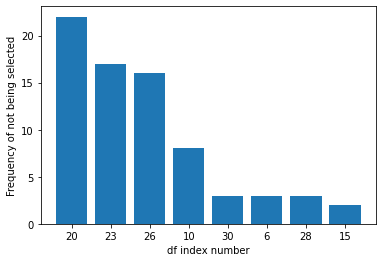

In [202]:
unknown_author_freq = Counter(flatten(count_vals)).most_common()
                    
x_vals = [str(val[0]) for val in unknown_author_freq]
y_vals = [val[1] for val in unknown_author_freq]

plt.bar(x_vals, y_vals)
plt.xticks(x_vals)
plt.ylabel('Frequency of not being selected')
plt.xlabel('df index number')
plt.show()

In [210]:
three_most_likely_ind = Counter(flatten(count_vals)).most_common(3)

three_most_likely_midi = [df.iloc[val[0]]['midi'] for val in three_most_likely_ind]
print(f'The three most-likey compositions to not be written by the 4 known composers are')
print(three_most_likely_midi)

The three most-likey compositions to not be written by the 4 known composers are
['0.337517805339117_adj.mid', '0.36321860283443286_adj.mid', '0.549470161204349_adj.mid']


## Discussion and Improvements
Since two pieces of musics written by two different people can sound very similar, I'm not really sure I would say we are noise limited. Also, any of these 4 composers are so famous and wrote so many pieces, that they have pieces that do not sound like their other pieces, and do sound like pieces written by other people.

I do not think data limited applies here, or a 'limit imposed on the amount of data that can be transferred to an electronic device'. I think the midi files were fairly complete.

The discussion on underfitting vs overfitting is interesting. Before I tried the KNN model, I would've argued that the data was underfitted due to lack of data. However, after using KNN, and taking many iterations of the results to find a distribution of the 'midi files with unknown composers', I do think it's close to optimal. Obviously, it's not 100% accurate, but I think that would be:
   1. 100% accuracy would probably need lots of data with no noise, which isn't realistic
   2. if 100% was ever achieved, it would probably be overfitted for these four composers
   3. some of these composers are going to have songs that sound like one anothers, so it's should be wrong occasionally 

Lastly, I would probably improve the model by figuring out how to collect more useful features from the midi files. This was my first time looking at midi file data. Also, collecting more data of the same composers or data with other composers that can be labeled as 'other' would improve the model. There's also an argument for doing a more robust hyperparameter study on the KNN (and other) model(s) to find the most optimal solution. There's probably a need to test for more missing data as well.